In [1]:
# Import libraries needed for analysis
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

**Global Sensitivity Analysis tutorial (using PAWN method)**

This notebook will take you through a global sensitivity analysis to determine the influential and uninfluential parameters of a hydrological model. The hydrological model we have used is the Hymod model (Boyle 2001; Wagener et al. 2001) which only has 5 parameters. The Global Sensitivity Analysis (GSA) allows us to determine the relative importance of each of the parameters on the model predictions, and therefore points us towards the most influential parameters on which estimation efforts should be focused on.


In [2]:
## Install the SAFE Toolbox 
# https://safetoolbox.github.io/ 
!pip install safepython
import safepython

     |████████████████████████████████| 77 kB 1.1 MB/s eta 0:00:011


In [3]:
## Import scripts from the SAFE Toolbox 
from __future__ import division, absolute_import, print_function

import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatRangeSlider, IntRangeSlider
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore') # to hide warning messages
# Module to perform PAWN:
import safepython.PAWN as PAWN
# Module to visualize the results:
import safepython.plot_functions as pf
# Module to execute the model
from safepython.model_execution import model_execution
# Functions to perform the input sampling
from safepython.sampling import AAT_sampling, AAT_sampling_extend
# Function to calculate RMSE:
from safepython.util import aggregate_boot, RMSE
# Module that simulates the HyMod model:
from safepython import HyMod

In [4]:
# Check working directory 
os.getcwd()

'/home/jovyan'

**Load and plot data**

In [6]:
# Read in observed data - this needs to be manually uploaded to the visualisation but can be downloaded as a dataset from DAFNI (Leaf Catchment Data, ID: d30c0e82-9b0f-4708-aa89-2841ce93a71c)
# Load data (one year of daily observations of rainfall, potential evaporation and flow):
data = np.genfromtxt('/home/jovyan/LeafCatch.txt', comments='%')
rain = data[0:365, 0] # select the first year of data
evap = data[0:365, 1]
flow = data[0:365, 2]
warmup = 30 # Model warmup period (days)

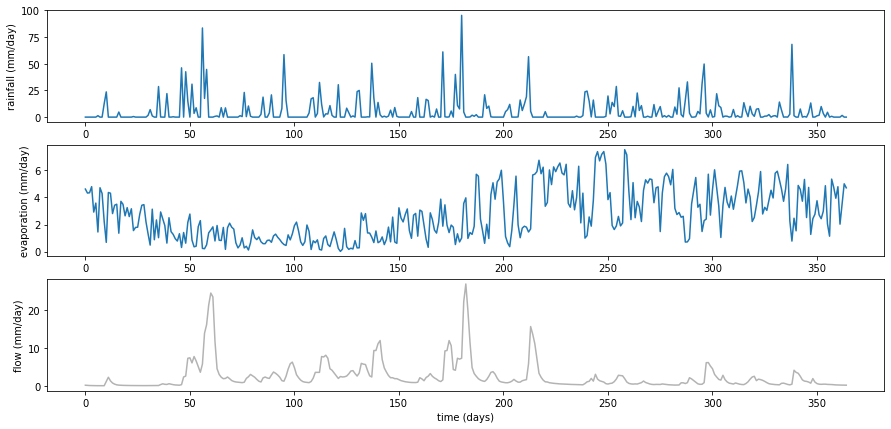

In [7]:
# Plot observed data:
plt.figure(figsize=[15,7])
plt.subplot(311); plt.plot(rain); plt.ylabel('rainfall (mm/day)')
plt.subplot(312); plt.plot(evap); plt.ylabel('evaporation (mm/day)')
plt.subplot(313); plt.plot(flow, color=[0.7, 0.7, 0.7]); plt.ylabel('flow (mm/day)')
plt.xlabel('time (days)')
plt.show()

In [8]:
# Get path to data folder which contains outputs from the DAFNI workflow and model runs
datfolder = os.path.join(os.environ.get("HOME"), "data")

In [72]:
# Read in flow output and parameter files from DAFNI workflow 

os.chdir(os.path.join(datfolder, os.listdir(datfolder)[0]))

params_output = pd.DataFrame()
all_files = os.listdir()
filtered_files_param = [file for file in all_files if file.endswith('params.csv')]

for x, file in enumerate(filtered_files_param): 
    params_output = params_output.append(pd.read_csv(file, header = None).iloc[:,0])

params_output.columns = ['Sm', 'beta', 'alfa', 'Rs', 'Rf']
    
flow_output = pd.DataFrame()
all_files = os.listdir()
filtered_files = [file for file in all_files if file.endswith('flow_sim.csv')]

for x, file in enumerate(filtered_files): 
    params = pd.read_csv(str(file.replace('-flow_sim.csv', "")) + '-params.csv', header = None)
    #print(params[0])
    flow_output[x] = pd.read_csv(file, header = None).iloc[:,0]

In [13]:
## Define BIAS function 

from numpy.matlib import repmat

def BIAS(y_sim, y_obs):

    """Computes the bias (absolute mean error)

    bias = BIAS(Y_sim,y_obs)

    Y_sim = time series of modelled variable     - matrix (N,T)
            (N>1 different time series can be evaluated at once)
    y_obs = time series of observed variable     - vector (1,T)

    bias   = vector of BIAS coefficients           - vector (N,1)

    """

    Nsim = y_sim.shape
    if len(Nsim) > 1:
        N = Nsim[0]
        T = Nsim[1]
    elif len(Nsim) == 1:
        T = Nsim[0]
        N = 1
        y_sim_tmp = np.nan * np.ones((1,T))
        y_sim_tmp[0,:] = y_sim
        y_sim = y_sim_tmp

    Nobs = y_obs.shape
    if len(Nobs) > 1:
        if Nobs[0] != 1:
             raise ValueError('"y_obs" be of shape (T, ) or (1,T).')
        if Nobs[1] != T:
            raise ValueError('the number of elements in "y_obs" must be equal to the number of columns in "y_sim"')
    elif len(Nobs) == 1:
        if Nobs[0] != T:
            raise ValueError('the number of elements in "y_obs" must be equal to the number of columns in "y_sim"')
        y_obs_tmp = np.nan * np.ones((1,T))
        y_obs_tmp[0,:] = y_obs
        y_obs = y_obs_tmp


    bias = abs(np.mean(y_sim - repmat(y_obs, N, 1), axis=1))

    return bias

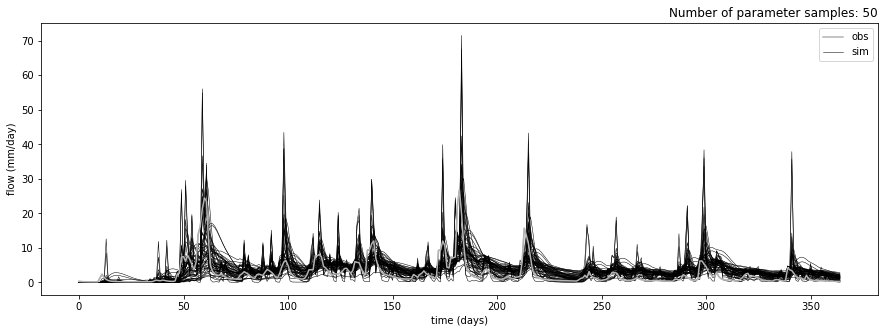

In [73]:
# Define input variability space:
X_Labels = ['Sm', 'beta', 'alfa', 'Rs', 'Rf'] # Name of parameters (used to customize plots)
M = len(X_Labels) # Number of parameters

## Collate flow results 
QQ= flow_output.T.to_numpy()


# Plot Monte Carlo (MC) simulations results and compare with data:
plt.figure(figsize=[15,5])
plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
plt.plot(np.transpose(QQ), 'k', linewidth = 0.5)
plt.plot(flow, color=[0.7, 0.7, 0.7])
plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
plt.legend(['obs', 'sim'])
plt.title("Number of parameter samples: 50", loc='right')
plt.show()

In [79]:
# Calculate RMSE and BIAS for each parameter sample:
YY = np.nan * np.ones((50, 2))
YY[:, 0] = RMSE(QQ[:, warmup:365], flow[warmup:365])
YY[:, 1] = BIAS(QQ[:, warmup:365], flow[warmup:365])

# Define interactive visualisation function to produce scatter plots for the chosen output metrics:
def scatter_function(metric='RMSE'):
    if metric == 'RMSE':
        i = 0
    elif metric == 'BIAS':
        i = 1
            
    # Extract output metric:
    Y = YY[:, i]; 
    Y_Label = metric + '(mm/day)'

    # Scatter plots of the output metric against input samples:
    plt.figure(figsize=[15,3])
    pf.scatter_plots(params_output.to_numpy(), Y, Y_Label=Y_Label, X_Labels=X_Labels)
    plt.title("Number of parameter samples:50", loc='right')
    plt.show()
    
interact(scatter_function, metric = ['RMSE','BIAS']);

interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS'), value='RMSE'), Output()), _dom_…

In [81]:
# Define interactive visualisation function to calculate and visualise sensitivity indices
# for the chosen output metric and different choices of the PAWN tuning parameters (n,Nboot,aggr)

def pawn_function(metric='RMSE', n = 5, aggr = 'median',Nboot = 500):
    # Extract output metric:
    if metric == 'RMSE':
        i = 0
    elif metric == 'BIAS':
        i = 1   
    Y = YY[:, i]; 
    
    # Apply PAWN
    # Tuning parameters:
    # n = number of conditioning intervals
    # aggr = statistic to aggregate KS values
    # Nboot = number of bootstrapping resamples used to derive confidence bounds of sensitivity indices   

    # Compute sensitivity indices for Nboot bootstrap resamples
    KS_median, KS_mean, KS_max = PAWN.pawn_indices(params_output.to_numpy(), Y, n, Nboot=Nboot)
    # KS_median and KS_mean and KS_max have shape (Nboot, M)
        
    # Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples:
    KS_median_m, KS_median_lb, KS_median_ub = aggregate_boot(KS_median) # shape (M,)
    KS_mean_m, KS_mean_lb, KS_mean_ub = aggregate_boot(KS_mean) # shape (M,)
    KS_max_m, KS_max_lb, KS_max_ub = aggregate_boot(KS_max) # shape (M,)

    # Plot sensitivity indices:
    plt.figure()
    plt.title("Output metric = %s" % metric)
    if aggr == 'median':
        pf.boxplot1(KS_median_m, S_lb=KS_median_lb, S_ub=KS_median_ub, X_Labels=X_Labels, Y_Label='sensitivity (median KS)')
    if aggr == 'mean':
        pf.boxplot1(KS_mean_m, S_lb=KS_mean_lb, S_ub=KS_mean_ub, X_Labels=X_Labels, Y_Label='sensitivity (mean KS)')
    if aggr == 'max':
        pf.boxplot1(KS_max_m, S_lb=KS_max_lb, S_ub=KS_max_ub, X_Labels=X_Labels, Y_Label='sensitivity (max KS)')
    plt.show()
    
interact(pawn_function, metric = ['RMSE','BIAS'], n = (2, 20, 1), aggr = ['median', 'mean','max'], Nboot = (0, 500, 10));

interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS'), value='RMSE'), IntSlider(value=…